![alt text](../img/lenet2.png)

![alt text](../img/lenet_table.png)

In [1]:
import gc

QUICK_RUN = True    # не пересчитывать, если результаты уже сохранены
                    # иначе - пересчет около 3 часов на RTX2060

# Вспомогайки

[на основе](https://github.com/mrTahion/Neural_Networks_and_CV_stepik)

In [2]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from cycler import cycler

monochrome = (cycler('color', ['k']) * cycler('marker', ['', '.']) *
              cycler('linestyle', ['-', '--', ':', '-.']))

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15, 6)})

def acc_loss_graph(accuracies, losses, net_list):
    plt.rc('axes', prop_cycle=monochrome)
    fig, (ax1, ax2) = plt.subplots(1, 2)

    for experiment_id in net_list:
        ax1.plot(accuracies[experiment_id], label=experiment_id)
    ax1.legend()
    ax1.set_title('Validation Accuracy')

    for experiment_id in net_list:
        ax2.plot(losses[experiment_id], label=experiment_id)
    ax2.legend()
    ax2.set_title('Validation Loss')
    
    fig.tight_layout()


# Давайте видеоизменим LeNet, чтобы повысить качество на валидации

Что нас не устраивает:
- активация тангенсами/сигмоидами (затухание градиента на глубоких сетях)
- свёртки 5х5 (25 весов, а каскад 2 по 3х3 - 18 весов и рецептивное поле такое же)
- average pooling (макс-пуллинг стабильнее)
- нет батч-нормализации (она ускоряет обучение)

In [3]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
import torchvision.datasets

In [5]:
import os

DATA_HOME = os.environ["DATA_HOME"]     # мне так удобно
DATA_HOME

'/mnt/INT_STORAGE/_data_models'

CIFAR-10 dataset (Canadian Institute For Advanced Research) 
- 10 классов

In [6]:
CIFAR_train = torchvision.datasets.CIFAR10(f"{DATA_HOME}/torchvision", download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10(f"{DATA_HOME}/torchvision", download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [8]:
len(y_train), len(y_test)

(50000, 10000)

In [9]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

Переведем яркость в [0, 1]

In [10]:
X_train /= 255.
X_test /= 255.

In [11]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

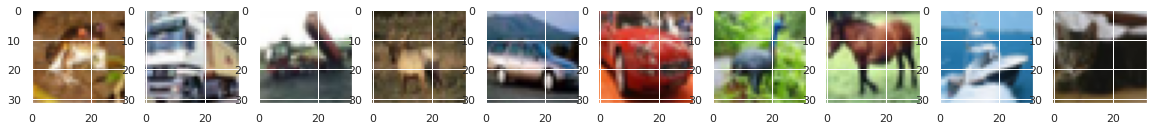

In [12]:
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [13]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

- нужно переставить размерности по торч

In [14]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [15]:
X_train.shape

torch.Size([50000, 3, 32, 32])

Надо отдельно сказать про слои батч-нормализации. Они вызываются с помощью слоя torch.nn.BatchNorm2d, потому что мы имеем дело с картинками. Если бы мы хотели нормализовать некоторый вектор после, например fully-connected слоя, то мы бы использовали torch.nn.BatchNorm1d. И на вход нужно передать num_features, то есть то количество каналов, которое имеет картинка или тензор перед батч-нормализацией.

In [16]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5, 
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        if conv_size == 5: # либо 1 свертка, но 5х5
            self.conv1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=5, padding=0)
        elif conv_size == 3: # либо 2, но по 3х3
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

Пока мы не использовали батч-нормализацию, нам не нужно было проставлять флажки - сеть находится в "train" режиме, или в "evaluation". Но дело в том, что батч-нормализация происходит не в момент вычисления градиентов (не в момент backward), а в момент forward.

В данном случае это сигнал слою батч-нормализации продолжать ли накапливать статистику по МО и СКО батчей или брать накопленные для расчетов

In [17]:
import time
from tqdm import tqdm

def train(net, X_train, y_train, X_test, y_test, batch_size=256, epochs=25, lr=1.0e-3, weight_decay=0, verbose=True, googlenet=False):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    
    t = time.time()

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    tqdm._instances.clear() 
    for epoch in range(epochs) if verbose else tqdm(range(epochs)):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            if googlenet:
                preds, aux1, aux2 = net.forward(X_batch)    # включает промежуточные выходы aux1, aux2
                # loss_value, loss_aux1, loss_aux2  = loss(preds, y_batch), loss(aux1, y_batch), loss(aux2, y_batch)
                # loss_value.backward(retain_graph=True), loss_aux1.backward(retain_graph=True), loss_aux2.backward(retain_graph=True)
                # To avoid having to use retain_graph=True you could just do loss = loss1 + loss2 then loss.backward()
                loss_value = loss(preds, y_batch) + loss(aux1, y_batch) + loss(aux2, y_batch)
            else:
                preds = net.forward(X_batch)
                loss_value = loss(preds, y_batch)
            
            loss_value.backward()
            optimizer.step()

        net.eval()
        with torch.no_grad():   # если с градиентом - забивается память gpu
            test_preds = net.forward(X_test)    # googlenet в режиме eval выдает только финальные логиты, поэтому ОК
            loss_value = loss(test_preds, y_test).item()
            test_loss_history.append(loss_value)

            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
            test_accuracy_history.append(accuracy)

            if verbose:
                print('Train Epoch: {} Time: {} Accuracy: {}, GPU_Mem_alloc: {} GPU_Mem_reserved: {}'\
                    .format(epoch, time.strftime("%H:%M:%S", time.gmtime(time.time() - t)), accuracy, \
                                torch.cuda.memory_allocated(), torch.cuda.memory_reserved()))

    return test_accuracy_history, test_loss_history

- чтоб не утекала пямять, в расчете метрик на валидации нужно прописать `with torch.no_grad()`
  - и получать расчитанные значения через атрибут `item`

In [18]:
import os
import json

JSON_NAME = "module06_cifar.json"

if QUICK_RUN and os.path.isfile(JSON_NAME):
    with open(JSON_NAME) as fp:
        accuracies, losses = json.load(fp)
else:
    accuracies, losses = {}, {}

print("Cases loaded:", *accuracies.keys())

Cases loaded: tanh relu relu_3 relu_3_max_pool relu_3_max_pool_bn cifar_net resnet18 resnet18_pretrained resnet34 resnet34_pretrained googlenet googlenet_pretrained resnet20_CIFAR resnet32_CIFAR resnet110_CIFAR resnet110_CIFAR w/o BN resnet20_CIFAR dout=0.15 resnet20_CIFAR dout=0.3 resnet20_CIFAR dout=0.5 resnet20_CIFAR dout=0.8 resnet20_CIFAR wd=1e-2 resnet20_CIFAR  wd=1e-3 resnet20_CIFAR  wd=1e-4 resnet20_CIFAR  wd=1e-5 resnet101_pretrained resnet101_pretrained_L2


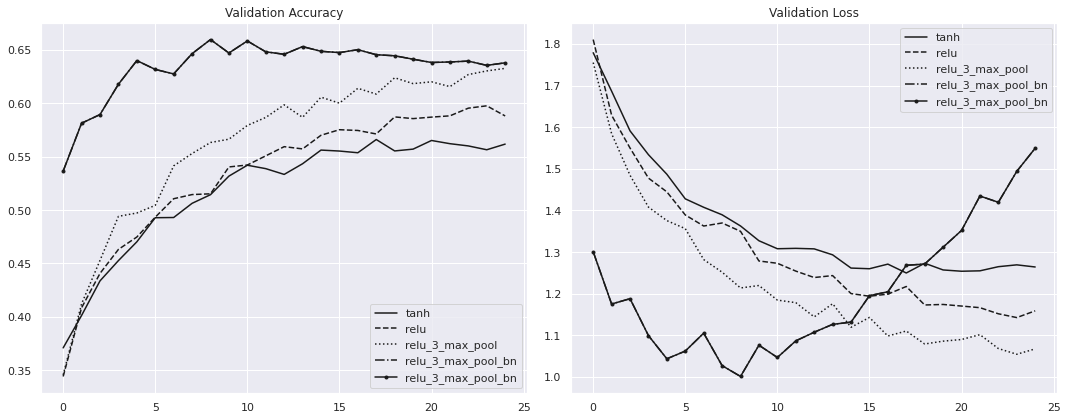

In [19]:
if not accuracies.get('tanh', False):
    accuracies['tanh'], losses['tanh'] = \
        train(LeNet5(activation='tanh', conv_size=5),
            X_train, y_train, X_test, y_test, verbose=False)

if not accuracies.get('relu', False):
    accuracies['relu'], losses['relu'] = \
        train(LeNet5(activation='relu', conv_size=5),
            X_train, y_train, X_test, y_test, verbose=False)

if not accuracies.get('relu_3', False):
    accuracies['relu_3'], losses['relu_3'] = \
        train(LeNet5(activation='relu', conv_size=3),
            X_train, y_train, X_test, y_test, verbose=False)

if not accuracies.get('relu_3_max_pool', False):
    accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
        train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
            X_train, y_train, X_test, y_test, verbose=False)

if not accuracies.get('relu_3_max_pool_bn', False):
    accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
        train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
            X_train, y_train, X_test, y_test, verbose=False)

with open(JSON_NAME, "w") as fp:
    json.dump([accuracies, losses], fp)

acc_loss_graph(accuracies, losses, ['tanh', 'relu', 'relu_3_max_pool', 'relu_3_max_pool_bn', 'relu_3_max_pool_bn'])

In [20]:
gc.collect()
torch.cuda.empty_cache()

Что получилось:
- LeNet, изначальный - с тангненсами, без свёрток 3 на 3, без max pooling и без батч-нормализации получает самые плохие показатели качества.
- LeNet, в которых мы изменили активации - сделали там активации ReLU. Это дало целых 5% качества.
  - ReLU с 3 на 3 или 5 на 5 - нет никакой разницы
- max pooling добавляет нам ещё целых 5% качества
   - на любой задаче связанной с изображениями max pooling будет лучше
- особенность батч-нормализации: сетка с батч-нормализацией учится очень быстро
  - кроме того, мы видим также, что батч-нормализация и переобучается быстрее. Логично 

Очень интересный вопрос: почему качество переобученной сети ухудшается не так сильно - на графиках сетка всё ещё лучше предсказывает, чем, например стандартный LeNet с тангенсом.
- т.к. функция потерь кросс-энтропия, то очень уверенная в своих ответах переобученная сеть набирает на этом баллы (угадывая реже, но с уверенностью 0.9999, набирает меньшее значение функции потерь сети, угадывающей часто, но с уверенностью 0.3 или меньше (классов то 10)

# Увеличим глубину сети

Получилось неплохо улучшить результат LeNet на датасете CIFAR - мы улучшили результат на целых 10%, но реализация LeNet имела очень большой недостаток. Она предназначена для работы с цифрами в одноканальном изображении - цифры очень простые.

Давайте добавим фильтров и посмотрим - а если мы из изображения будем извлекать больше информации, может быть, и качество станет лучше

In [21]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)  # можно трактовать как предварительную нормировку по яркости

        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)   # 16 вых.каналов
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)  # 32 вых.каналов
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)  # 64 вых.каналов
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)       # после сверток будет кадр 8х8х64 канала
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        
        self.fc3   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)
        
        return x

In [22]:
def cnt_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Модель содержит {cnt_parameters(CIFARNet()):,} параметров')

Модель содержит 1,090,384 параметров


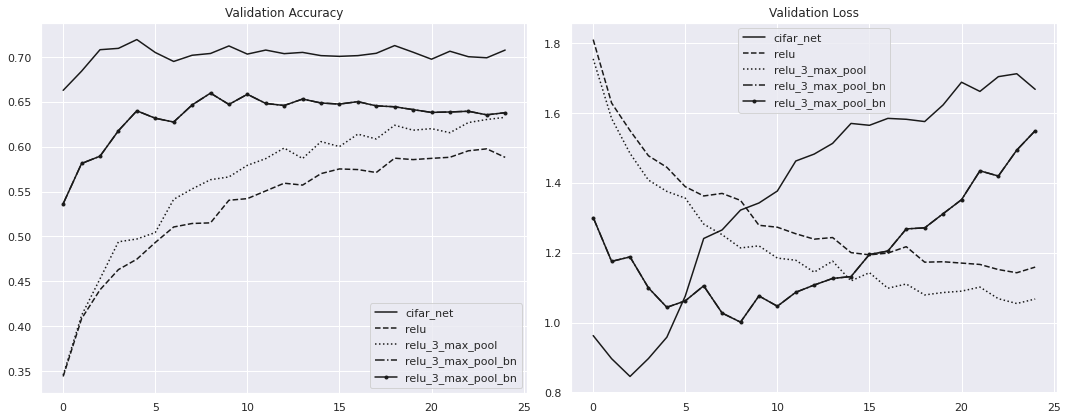

In [23]:
if not accuracies.get('cifar_net', False):
    accuracies['cifar_net'], losses['cifar_net'] = \
        train(CIFARNet(), X_train, y_train, X_test, y_test, verbose=False)

with open(JSON_NAME, "w") as fp:
    json.dump([accuracies, losses], fp)

acc_loss_graph(accuracies, losses, ['cifar_net', 'relu', 'relu_3_max_pool', 'relu_3_max_pool_bn', 'relu_3_max_pool_bn'])

In [24]:
gc.collect()
torch.cuda.empty_cache()

# Проверим утверждение про затухание градиента на практике

В документации pytorch можно найти следующие функции активации: 

`ELU, Hardtanh, LeakyReLU, LogSigmoid, PReLU, ReLU, ReLU6, RReLU, SELU, CELU, Sigmoid, Softplus, Softshrink, Softsign, Tanh, Tanhshrink, Hardshrink`

Вам предстоит найти активацию, которая приводит к наименьшему затуханию градиента. 

Для проверки мы сконструируем SimpleNet, которая будет иметь внутри 3 fc-слоя, по 1 нейрону в каждом без bias'ов. Веса этих нейронов мы проинициализируем единицами. На вход в эту сеть будем подавать числа из нормального распределения. Сделаем 200 запусков (NUMBER_OF_EXPERIMENTS) для честного сравнения и посчитаем среднее значение градиента в первом слое. Найдите такую функцию, которая будет давать максимальные значения градиента в первом слое. 

In [25]:
import torch
import numpy as np
from tqdm import tqdm

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

NUMBER_OF_EXPERIMENTS = 200

class SimpleNet(torch.nn.Module):
    def __init__(self, activation):
        super().__init__()

        self.activation = activation
        self.fc1 = torch.nn.Linear(1, 1, bias=False)  # one neuron without bias
        self.fc1.weight.data.fill_(1.)  # init weight with 1
        self.fc2 = torch.nn.Linear(1, 1, bias=False)
        self.fc2.weight.data.fill_(1.)
        self.fc3 = torch.nn.Linear(1, 1, bias=False)
        self.fc3.weight.data.fill_(1.)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return x

    def get_fc1_grad_abs_value(self):
        return torch.abs(self.fc1.weight.grad)

def get_fc1_grad_abs_value(net, x):
    output = net.forward(x)
    output.backward()  # no loss function. Pretending that we want to minimize output
                       # In our case output is scalar, so we can calculate backward
    fc1_grad = net.get_fc1_grad_abs_value().item()
    net.zero_grad()
    return fc1_grad


activations =  {
    'ELU': torch.nn.ELU(),
    'Hardtanh': torch.nn.Hardtanh(),
    'LeakyReLU': torch.nn.LeakyReLU(),
    'LogSigmoid': torch.nn.LogSigmoid(),
    'PReLU': torch.nn.PReLU(),
    'ReLU': torch.nn.ReLU(),
    'ReLU6': torch.nn.ReLU6(),
    'RReLU': torch.nn.RReLU(),
    'SELU': torch.nn.SELU(),
    'CELU': torch.nn.CELU(),
    'Sigmoid': torch.nn.Sigmoid(),
    'Softplus': torch.nn.Softplus(),
    'Softshrink': torch.nn.Softshrink(),
    'Softsign': torch.nn.Softsign(),
    'Tanh': torch.nn.Tanh(),
    'Tanhshrink': torch.nn.Tanhshrink(),
    'Hardshrink': torch.nn.Hardshrink()}

mean_grads = {}
for name, func in tqdm(activations.items()):
    net = SimpleNet(activation=func)

    fc1_grads = []
    for x in torch.randn((NUMBER_OF_EXPERIMENTS, 1)):
        fc1_grads.append(get_fc1_grad_abs_value(net, x))

    mean_grads[name] = np.mean(fc1_grads)

for name, grad in mean_grads.items():
    print(f"{name}: {np.mean(grad):.3f}")

sorted(mean_grads.items(), key=lambda x: x[1])[-1]

100%|██████████| 17/17 [00:01<00:00,  8.79it/s]

ELU: 0.456
Hardtanh: 0.341
LeakyReLU: 0.455
LogSigmoid: 0.255
PReLU: 0.421
ReLU: 0.383
ReLU6: 0.381
RReLU: 0.378
SELU: 0.617
CELU: 0.519
Sigmoid: 0.008
Softplus: 0.260
Softshrink: 0.202
Softsign: 0.065
Tanh: 0.161
Tanhshrink: 0.022
Hardshrink: 0.669


('Hardshrink', 0.668816843032837)

$\text{HardShrink}(x)=\begin{cases} x, если \ x > \lambda &(\lambda_{\text{def}}=0.5 \text) \\ x, если \ x < -\lambda \\ 0, иначе \\ \end{cases}$

- жостко сужает область зануления градиента до $[-\lambda,+\lambda]$, в остальной области градиент равен градиенту аргумента

**Попробуйте решить следующую задачу пользуясь только бумагой и калькулятором**:

Допустим, у нас есть нейросеть, состоящая из 4-х полносвязных слоев, в каждом из которых по одному нейрону. Для простоты будем считать, что `bias`'ы у нейронов отсутствуют, а все веса равны 1.

После каждого слоя мы поставим активации. В первом случае это будут `tanh`, во втором - `ReLU`. Не будем добавлять никакую loss-функцию. Тогда нашу сеть можно будет записать в виде функции:

$f = a_4(w_4 \cdot a_3(w_3 \cdot a_2(w_2 \cdot a_1(w_1 \cdot x))))$

Где $a$ - это либо `tanh` либо `ReLU`. $w_i$ - это одно число.

Пусть на вход подали $x=100$

Зная, что $tanh'(x) = 1 - tanh^2(x)$, рассчитайте градиенты весов сети: $[f'_{w_1}, f'_{w_2}, f'_{w_3}, f'_{w_4}, ]$ для случая `a=tanh` и для случая `a=ReLU`. Результат округлите до 3-го знака.

Правда ли, что для активаций гиперболическим тангенсом, градиенты затухают быстрее?

$a_i = th$
$$\partial f / \partial w_4 = (1 - \th^2(\th\th\th 100))\th\th\th 100 = 0.4361 \\
\partial f / \partial w_3 = (1 - \th^2(\th\th\th 100)) (1 - \th^2(\th\th 100))\th\th 100 = 0.3041 \\
\partial f / \partial w_2 = (1 - \th^2(\th\th\th 100)) (1 - \th^2(\th\th 100)) (1 - \th^2(\th 100))\th 100 = 0.1677 \\
\partial f / \partial w_1 = (1 - \th^2(\th\th\th 100)) (1 - \th^2(\th\th 100)) (1 - \th^2(\th 100)) (1 - \th^2 100)100 = 0.0 \\$$

$a_i = ReLU$

$$\partial f / \partial w_i = x = 100.0, \forall i$$

# Сравнение с ResNet

1. Из библиотеки torchvision (ставится вместе с pytorch), можно проимпортировать ResNet18 командой "from torchvision.models import resnet18". Вот так просто. Сравните результаты resnet18 и CIFARNet. Какая сеть дает лучший результат?
2. Попробуйте, пользуясь нашей лекцией и описанием архитектуры из оригинальной статьи, написать собственную реализацию ResNet20. Если возникнут сомнения, можно свериться с кодом из https://github.com/akamaster/pytorch_resnet_cifar10 . Удалось ли побить resnet18?
3. Реализуйте ResNet110 (возможно, придется уменьшить размер batch'a). Проверьте утверждение, что ResNet110 не обучается (или обучается в 10% случаев), если отключить BatchNorm.
4. Добавьте Dropout2d после каждого BatchNorm2d для ResNet20. Есть ли положительный эффект? Как параметр "p" этого слоя влияет на accuracy и на переобучение? 
5. Добавьте l2-регуляризацию. В PyTorch она активируется с помощью параметра weight_decay в оптимизаторе. Значение обычно выбирают из [1e-3, 1e-4, 1e-5]. Значение 1e-2 ставить не стоит, т.к. сеть не сможет учиться,  а 1e-6 скорее всего просто не повлияет на обучение (но лучше это проверить утверждение самостоятельно).

In [26]:
from torchvision.models import resnet18
from torchvision.models import resnet34

if not accuracies.get('resnet18', False):
    accuracies['resnet18'], losses['resnet18'] = \
        train(resnet18(), X_train, y_train, X_test, y_test, verbose=False)

if not accuracies.get('resnet18_pretrained', False):
    accuracies['resnet18_pretrained'], losses['resnet18_pretrained'] = \
        train(resnet18(pretrained=True), X_train, y_train, X_test, y_test, verbose=False) # 44.7MB (ImageNet)

if not accuracies.get('resnet34', False):
    accuracies['resnet34'], losses['resnet34'] = \
        train(resnet34(), X_train, y_train, X_test, y_test, verbose=False)

if not accuracies.get('resnet34_pretrained', False):
    accuracies['resnet34_pretrained'], losses['resnet34_pretrained'] = \
        train(resnet34(pretrained=True), X_train, y_train, X_test, y_test, verbose=False) # 44.7MB (ImageNet)

In [27]:
with open(JSON_NAME, "w") as fp:
    json.dump([accuracies, losses], fp)

- 25 эпох 
  - resnet18 - 5.5 минут 
  - resnet34 - 7.5 минут

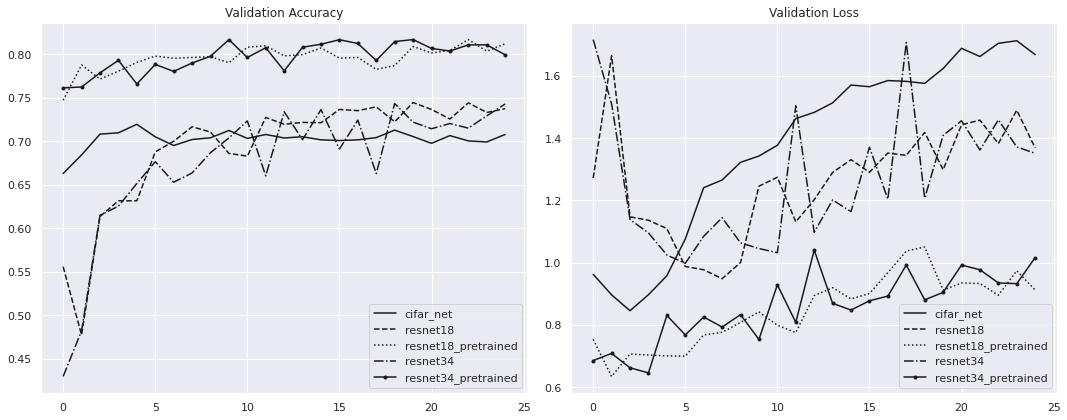

In [28]:
acc_loss_graph(accuracies, losses, ['cifar_net', 'resnet18', 'resnet18_pretrained', 'resnet34', 'resnet34_pretrained'])

In [29]:
gc.collect()
torch.cuda.empty_cache()

**Что получается:**
- ResNet на выходе имеет полносвязный слой на 1000 классов (по-умочанию), но он прекрасно работает с меньшим количеством классов
  - сеть обучается подсвечивать те выходы, которые соответствуют классам обучающей выборки, остальные не задействуются
  - для порядку лучше передавать количество классов, хотя на производительность это не повлияет практически
- большой разницы в качестве resnet18 и resnet34 нет
- предобученные варианты ResNet показывают намного более высокое качество классификации (+(5-7)%)
  - такие варианты также очень быстро переобучаются (оптимальное количество эпох для трансфер-обучения 2-3 эпохи)
    - наверно и шаг надо уменьшать...
    - как пишут с мест, обычно если сеть разморожена, то большой lr приводит к большим градиентам на первых эпохах, т.к в начале обучения очень большой loss. Эти большие градиенты приводят к тому, что даже на первых сверточных слоях сильно портятся активационные карты (конечно, если они были предобучены, иначе понятие "портятся" неприменимо) Выход такой: размораживать сеть постепенно, начиная с последних слоев. Можно смотреть при этом на loss: как только вышел на плато - размораживаем следующий слой

**1. Сравните результаты resnet18 и CIFARNet. Какая сеть дает лучший результат?**
- resnet18: +(2-3)%

### Посмотрим, кстати, что покажет GoogLeNet

Обучение с 0 нужно модифицировать по сравнению с остальными моделями, т.к. метод `forward` возвращает кортеж, включающий промежуточные выходы для распространения градиента вглубь сети.
- однако, pretrained вариант почему-то выдает без промежуточных выходов, поэтому там googlenet=False
  - видимо имеется в виду, что при трансферт обучении нужно просто немного подкрутить последние слои...

In [30]:
from torchvision.models import googlenet

if not accuracies.get('googlenet', False):
    accuracies['googlenet'], losses['googlenet'] = \
        train(googlenet(init_weights=True), X_train, y_train, X_test, y_test, verbose=False, googlenet=True) # Inception-v1 (как в лекции)

if not accuracies.get('googlenet_pretrained', False):
    accuracies['googlenet_pretrained'], losses['googlenet_pretrained'] = \
        train(googlenet(pretrained=True), X_train, y_train, X_test, y_test, verbose=False, googlenet=False)  # 49.7MB

In [31]:
with open(JSON_NAME, "w") as fp:
    json.dump([accuracies, losses], fp)

- 25 эпох - 6 минут

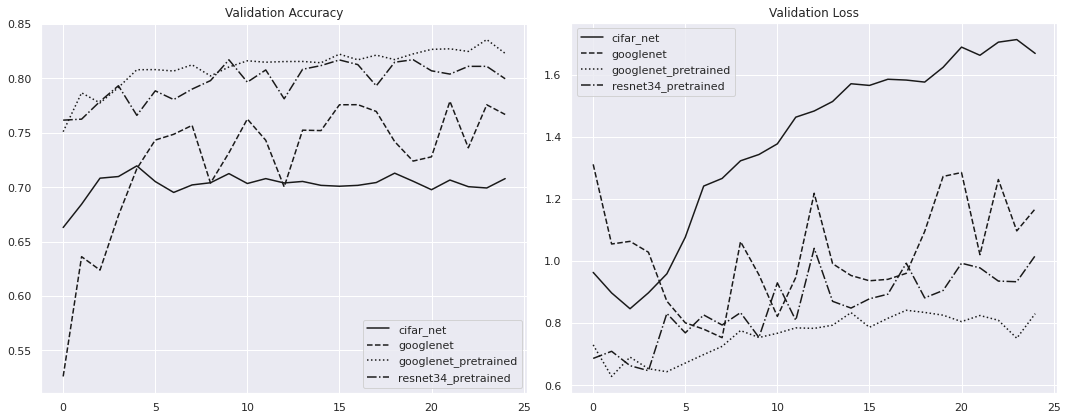

In [32]:
acc_loss_graph(accuracies, losses, ['cifar_net', 'googlenet', 'googlenet_pretrained', 'resnet34_pretrained'])

In [33]:
print(f"googlenet:\t{cnt_parameters(googlenet(pretrained=True)):,}\nresnet34:\t{cnt_parameters(resnet34()):,}")

googlenet:	6,624,904
resnet34:	21,797,672


- Точность `GoogLeNet` среди рассмотренных других обучаемых с нуля моделей самая высокая
  - Оптиммальное число эпох обучения: порядка 10
- Точность предобученного `GoogLeNet` на CIFAR10 на уровне предобученного `resnet34 + (2-3)%`
  - но параметров тут 6.6M против 21.8M в `resnet34`
    - несмотря на то, что параметров в 3 раза меньше, обучается столько же (видимо, из-за тройной функции потерь)
  - Оптимальное число эпох для трансфер-обучения: 2-3

In [34]:
gc.collect()
torch.cuda.empty_cache()

# ResNet для CIFAR

- все уже собрано в явном и красивом виде в `torchvision.models.ResNet`
- копируем, выкидываем "лишнее", радуемся
- потом внимательно [читаем](https://github.com/akamaster/pytorch_resnet_cifar10)
  - ... Moreover, most of the implementations on the web is copy-paste from torchvision's resnet and has wrong number of params
  - копируем заново

In [35]:
from torch import nn

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, option='A',
                 use_batch_norm=True, use_dropout=False, d_out_p=0.5):
        super().__init__()
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        self.d_out_p = d_out_p

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout2d(d_out_p)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != planes:
            if option == 'A':
                """w/o BottleNeck. For CIFAR10 ResNet paper uses option A"""
                self.shortcut = LambdaLayer(lambda x:
                                            nn.functional.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(inplanes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(self.expansion * planes))

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
            out = self.bn1(out)
        if self.use_dropout:
            out = self.dropout(out) 
        out = self.relu(out)
        out = self.conv2(out)
        
        if self.use_batch_norm:
            out = self.bn2(out)
        if self.use_dropout:
            out = self.dropout(out)

        out += self.shortcut(x) # residual connection (just padded to shape)
        out = self.relu(out)
        return out
        
class ResNet(nn.Module):
    """ https://arxiv.org/pdf/1512.03385.pdf
    The following table summarizes the architecture:
        output_map_size     32х32   16х16   8х8
        layers              1+2n    2n      2n
        filters             16      32      64
    """

    def __init__(self, block, num_blocks, num_classes=10, use_batch_norm=True, use_dropout=False, d_out_p=0.5):
        super(ResNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        self.d_out_p = d_out_p
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(d_out_p)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, 
                                use_batch_norm=self.use_batch_norm,
                                use_dropout=self.use_dropout, 
                                d_out_p=self.d_out_p))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
          out = self.bn1(out)
        if self.use_dropout:
          out = self.dropout(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

def test(net):  # оттуда же
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print(f"Total number of params {total_params:,}")
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))

Слои они считают как-то поразному...

In [36]:
test(ResNet(BasicBlock, [3, 3, 3])) # resnet20
test(ResNet(BasicBlock, [5, 5, 5])) # resnet32
test(ResNet(BasicBlock, [18, 18, 18])) # resnet110

test(resnet18()) # 18+3
test(resnet34()) # 34+3

Total number of params 269,722
Total layers 20
Total number of params 464,154
Total layers 32
Total number of params 1,727,962
Total layers 110
Total number of params 11,689,512
Total layers 21
Total number of params 21,797,672
Total layers 37


In [37]:
if not accuracies.get('resnet20_CIFAR', False):
    accuracies['resnet20_CIFAR'], losses['resnet20_CIFAR'] = \
        train(ResNet(BasicBlock, [3, 3, 3]), X_train, y_train, X_test, y_test, verbose=False)

if not accuracies.get('resnet32_CIFAR', False):
    accuracies['resnet32_CIFAR'], losses['resnet32_CIFAR'] = \
        train(ResNet(BasicBlock, [5, 5, 5]), X_train, y_train, X_test, y_test, verbose=False)

if not accuracies.get('resnet110_CIFAR', False):
    accuracies['resnet110_CIFAR'], losses['resnet110_CIFAR'] = \
        train(ResNet(BasicBlock, [18, 18, 18]), X_train, y_train, X_test, y_test, batch_size=64, verbose=False)

In [38]:
with open(JSON_NAME, "w") as fp:
    json.dump([accuracies, losses], fp)

25 эпох:
- resnet20 CIFAR - 4.5 минут
- resnet32 CIFAR - 7.5 минут
- resnet110 CIFAR - 41 минут (батч 64)

**В сравнении с сопоставимыми архитектурами, адаптированными под ImageNet и с топовой из полученных моделью**

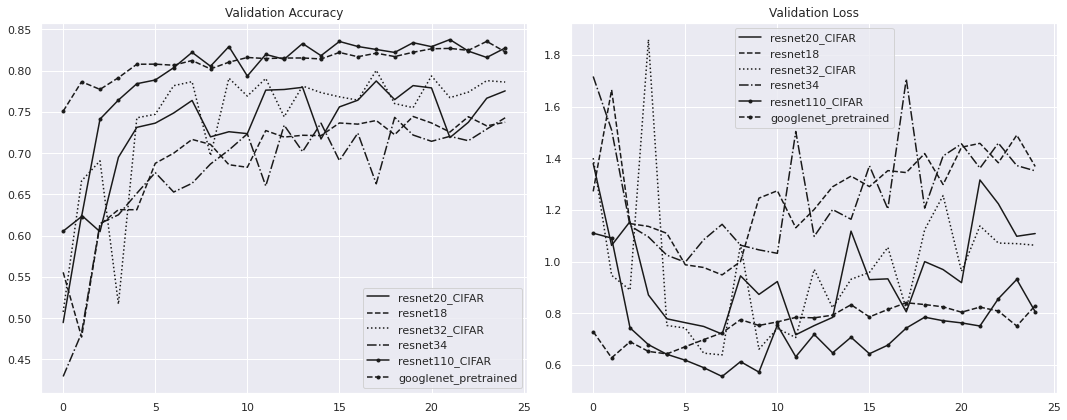

In [39]:
acc_loss_graph(accuracies, losses, ['resnet20_CIFAR', 'resnet18', 'resnet32_CIFAR', 'resnet34', 'resnet110_CIFAR', 'googlenet_pretrained'])

In [40]:
gc.collect()
torch.cuda.empty_cache()

Что можно сказать:
- "специально заточенная под **CIFAR**" оригинальная архитектура ResNet (`resnet20_CIFAR`) **показала преимущество в точности** перед заточенной под **ImageNet** оригинальной архитектурой ResNet (`resnet18`)
  - плюс небольшая прибавка в скорости вычислений
  - каналов сверток меньше в разы, параметров меньше на порядок, но скорость не так сильно изменилась
  - по памяти тоже вроде все так же, но она тут загадочным образом выделяется/освобождается
- `resnet110` очень близка по точности `GoogLeNet`, но нужно обучать с 0, а это долго

**2. Попробуйте, пользуясь нашей лекцией и описанием архитектуры из оригинальной статьи, написать собственную реализацию ResNet20. Если возникнут сомнения, можно свериться с кодом из https://github.com/akamaster/pytorch_resnet_cifar10 . Удалось ли побить resnet18?**

- да, примерно +5% точности

## Влияние батч-нормализации и дропаута

In [41]:
if not accuracies.get('resnet110_CIFAR w/o BN', False):
    accuracies['resnet110_CIFAR w/o BN'], losses['resnet110_CIFAR w/o BN'] = \
        train(ResNet(BasicBlock, [18, 18, 18], use_batch_norm=False), X_train, y_train, X_test, y_test, batch_size=64, verbose=False)

In [42]:
with open(JSON_NAME, "w") as fp:
    json.dump([accuracies, losses], fp)

25 эпох
- resnet110 (без батч-номализации) 25 минут

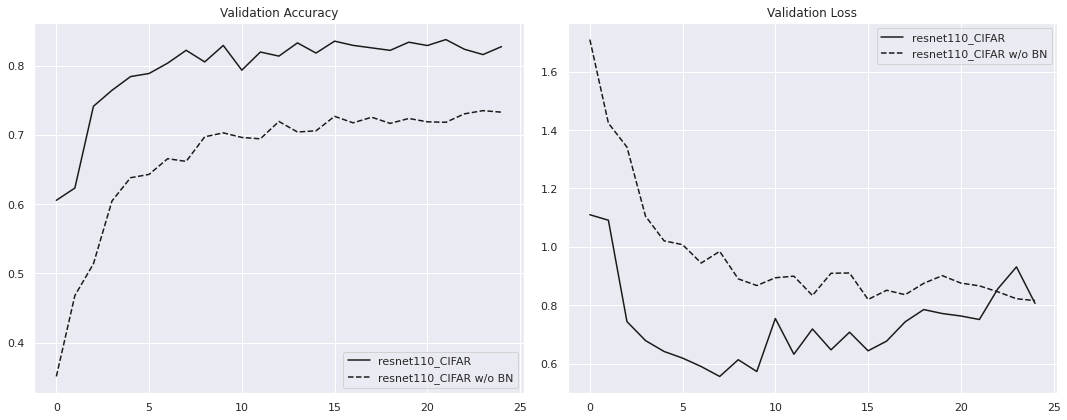

In [43]:
acc_loss_graph(accuracies, losses, ['resnet110_CIFAR', 'resnet110_CIFAR w/o BN'])

In [44]:
gc.collect()
torch.cuda.empty_cache()

**3. Реализуйте ResNet110 (возможно, придется уменьшить размер batch'a). Проверьте утверждение, что ResNet110 не обучается (или обучается в 10% случаев), если отключить BatchNorm.**

- того, на что намекают авторы, не видно, но мы верим, что так бывает
- без батч-нормализации глубокая сеть обучается, но очень медленно
- зато нет переобучения

In [45]:
if not accuracies.get('resnet20_CIFAR dout=0.15', False):
    accuracies['resnet20_CIFAR dout=0.15'], losses['resnet20_CIFAR dout=0.15'] = \
        train(ResNet(BasicBlock, [3, 3, 3], use_dropout=True, d_out_p=0.15), X_train, y_train, X_test, y_test, verbose=False)

if not accuracies.get('resnet20_CIFAR dout=0.3', False):
    accuracies['resnet20_CIFAR dout=0.3'], losses['resnet20_CIFAR dout=0.3'] = \
        train(ResNet(BasicBlock, [3, 3, 3], use_dropout=True, d_out_p=0.3), X_train, y_train, X_test, y_test, verbose=False)
        
if not accuracies.get('resnet20_CIFAR dout=0.5', False):
    accuracies['resnet20_CIFAR dout=0.5'], losses['resnet20_CIFAR dout=0.5'] = \
        train(ResNet(BasicBlock, [3, 3, 3], use_dropout=True, d_out_p=0.5), X_train, y_train, X_test, y_test, verbose=False)

if not accuracies.get('resnet20_CIFAR dout=0.8', False):
    accuracies['resnet20_CIFAR dout=0.8'], losses['resnet20_CIFAR dout=0.8'] = \
        train(ResNet(BasicBlock, [3, 3, 3], use_dropout=True, d_out_p=0.8), X_train, y_train, X_test, y_test, verbose=False)

Дропаут не дает такого сильного увеличения вычислений (25 эпох: 5 минут вместо 4.5), как батч-нормализация

In [46]:
with open(JSON_NAME, "w") as fp:
    json.dump([accuracies, losses], fp)

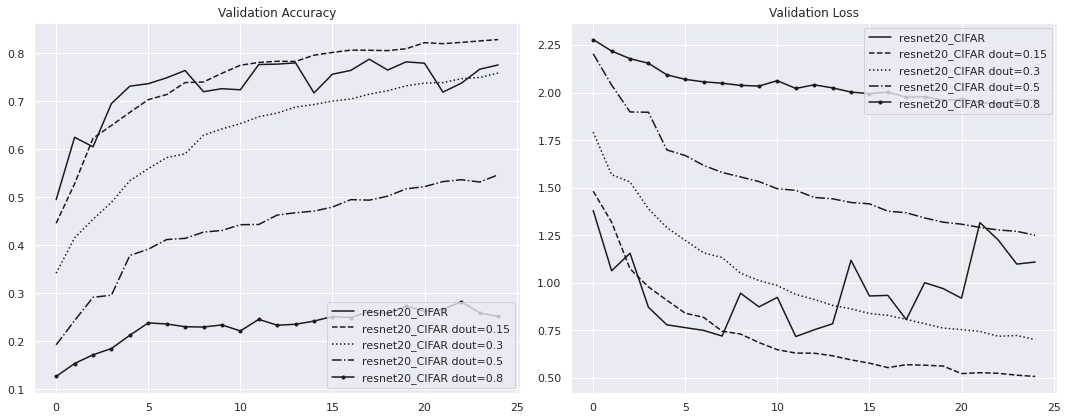

In [47]:
acc_loss_graph(accuracies, losses, ['resnet20_CIFAR', 'resnet20_CIFAR dout=0.15', 'resnet20_CIFAR dout=0.3', 'resnet20_CIFAR dout=0.5', 'resnet20_CIFAR dout=0.8'])

In [48]:
gc.collect()
torch.cuda.empty_cache()

**4. Добавьте Dropout2d после каждого BatchNorm2d для ResNet20. Есть ли положительный эффект? Как параметр "p" этого слоя влияет на accuracy и на переобучение?**

- дропаут действительно предотвращает переобучение
- большой дропаут делает обучение очень долгим
- небольшой дропаут позволяет также достичь более высокой точности
  - оптимально 0.15, точность в топе
  - 0.3 тоже ОК

## Влияние регуляризации Тихонова ($L_2$-регуляризации)

In [49]:
if not accuracies.get('resnet20_CIFAR wd=1e-2', False):
    accuracies['resnet20_CIFAR wd=1e-2'], losses['resnet20_CIFAR wd=1e-2'] = \
        train(ResNet(BasicBlock, [3, 3, 3]), X_train, y_train, X_test, y_test, weight_decay=1e-2, verbose=False)

if not accuracies.get('resnet20_CIFAR  wd=1e-3', False):
    accuracies['resnet20_CIFAR  wd=1e-3'], losses['resnet20_CIFAR  wd=1e-3'] = \
        train(ResNet(BasicBlock, [3, 3, 3]), X_train, y_train, X_test, y_test, weight_decay=1e-3, verbose=False)
        
if not accuracies.get('resnet20_CIFAR  wd=1e-4', False):
    accuracies['resnet20_CIFAR  wd=1e-4'], losses['resnet20_CIFAR  wd=1e-4'] = \
        train(ResNet(BasicBlock, [3, 3, 3]), X_train, y_train, X_test, y_test, weight_decay=1e-4, verbose=False)

if not accuracies.get('resnet20_CIFAR  wd=1e-5', False):
    accuracies['resnet20_CIFAR  wd=1e-5'], losses['resnet20_CIFAR  wd=1e-5'] = \
        train(ResNet(BasicBlock, [3, 3, 3]), X_train, y_train, X_test, y_test, weight_decay=1e-5, verbose=False)

In [50]:
with open(JSON_NAME, "w") as fp:
    json.dump([accuracies, losses], fp)

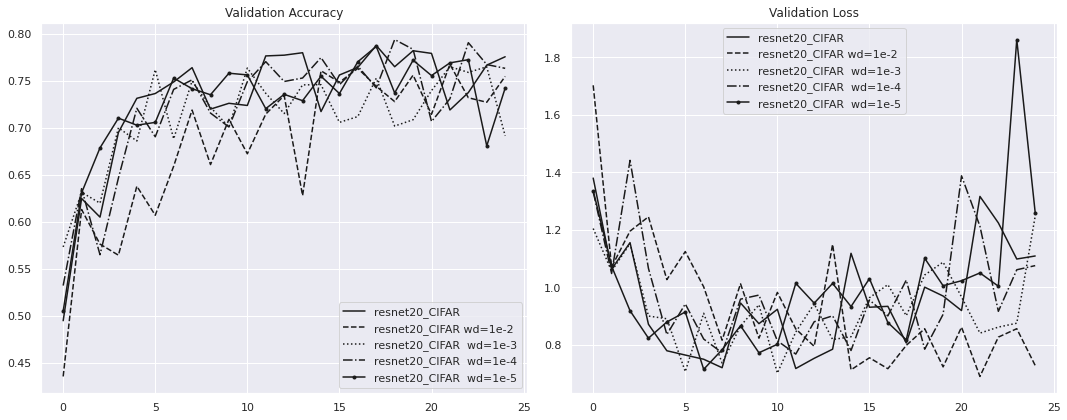

In [51]:
acc_loss_graph(accuracies, losses, ['resnet20_CIFAR', 'resnet20_CIFAR wd=1e-2', 'resnet20_CIFAR  wd=1e-3', 'resnet20_CIFAR  wd=1e-4', 'resnet20_CIFAR  wd=1e-5'])

**5. Добавьте l2-регуляризацию. В PyTorch она активируется с помощью параметра weight_decay в оптимизаторе. Значение обычно выбирают из [1e-3, 1e-4, 1e-5]. Значение 1e-2 ставить не стоит, т.к. сеть не сможет учиться,  а 1e-6 скорее всего просто не повлияет на обучение (но лучше это проверить самостоятельно).**

- обучаются примерно одинаково
- на уровне тенденции 1e-2 и 1e-3 лучше противостоят переобучению, но это не сильно проявляется
- 1e-5 не влияет на возможность переобучения модели

# GoogLeNet или ResNet101?

<img src="../img/qa.jpg" width="300">

- оба предобучены на Imagenet
- оба классифицируют CIFAR
  - т.е. сравнивать можно

In [52]:
from torchvision.models import resnet101

test(resnet101()) # 101+4

Total number of params 44,549,160
Total layers 105


In [53]:
if not accuracies.get('resnet101_pretrained', False):
    accuracies['resnet101_pretrained'], losses['resnet101_pretrained'] = \
        train(resnet101(pretrained=True), X_train, y_train, X_test, y_test, verbose=False) # 171MB (ImageNet)

In [54]:
with open(JSON_NAME, "w") as fp:
    json.dump([accuracies, losses], fp)

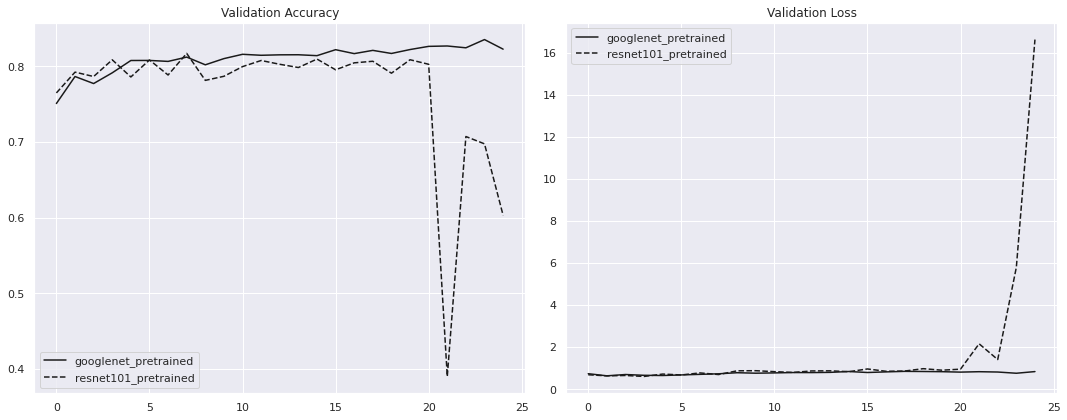

In [55]:
acc_loss_graph(accuracies, losses, ['googlenet_pretrained', 'resnet101_pretrained'])

`resnet101_pretrained` после 20 эпохи получила взрыв градиента
- надо видимо обучать с меньшим шагом
- имеет смысл добавить регуляризацию

В таком виде она не побила `googlenet`

**А ежели  так:**

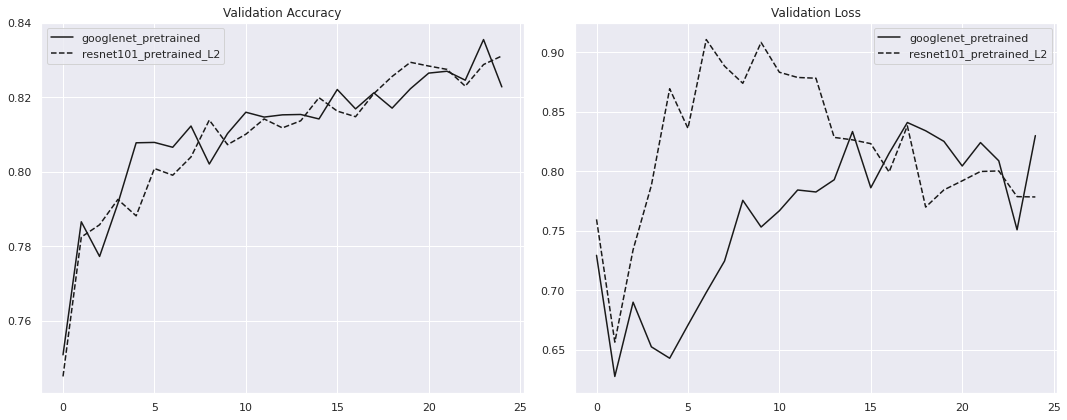

In [56]:
if not accuracies.get('resnet101_pretrained_L2', False):
    accuracies['resnet101_pretrained_L2'], losses['resnet101_pretrained_L2'] = \
        train(resnet101(pretrained=True), X_train, y_train, X_test, y_test, 
                                                                    lr=1e-4, 
                                                                    weight_decay=1e-3,
                                                                    verbose=False)

with open(JSON_NAME, "w") as fp:
    json.dump([accuracies, losses], fp)

acc_loss_graph(accuracies, losses, ['googlenet_pretrained', 'resnet101_pretrained_L2'])

In [59]:
test(resnet101())
test(googlenet(pretrained=True))

Total number of params 44,549,160
Total layers 105
Total number of params 6,624,904
Total layers 58


**В таком виде - без разницы**

# ВЫВОД

Лучшим вариантом будет 

- трансфер-обучение предобученной модели
- с добавлением дропаута 0.15
- с обучением с постепенной разморозкой слоев
- с аугментацией исходных данных

<img src="../img/fin.jpeg" width="300">